In [26]:
import torch
from pytorch_transformers import GPT2LMHeadModel, GPT2Tokenizer
from tqdm import tqdm as tqdm_notebook
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from IPython.core.display import display, HTML
import math

np.random.seed(1)
torch.manual_seed(1)

In [27]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
class Intervention():
    '''
    Wrapper for all the possible interventions
    '''
    def __init__(self,
                 base_string: str,
                 substitutes: list,
                 candidates: list):
        super()
        self.enc = tokenizer
        # All the initial strings
        # First item should be neutral, others tainted
        self.base_strings = [base_string.format(s)
                             for s in substitutes]
        # Tokenized bases
        self.base_strings_tok = [self._to_batch(s)
                                 for s in self.base_strings]
        # Where to intervene
        self.position = base_string.split().index('{}')

        # How to extend the string
        self.candidates = ['Ġ' + c for c in candidates]
        # tokenized candidates
        self.candidates_tok = [self.enc.convert_tokens_to_ids(c)
                               for c in self.candidates]

    def _to_batch(self, txt):
        encoded = self.enc.encode(txt)
        return torch.tensor(encoded, dtype=torch.long) \
            .unsqueeze(0) \
            .repeat(1, 1)

In [28]:
class Model():
    '''
    Wrapper for all model logic
    '''
    def __init__(self):
        super()
        self.model = GPT2LMHeadModel.from_pretrained('gpt2')
        self.model.eval()

        # Options
        # 12 for GPT-2
        self.num_layers = len(self.model.transformer.h)
        # 12 for GPT-2
        self.num_heads = self.model.transformer.h[0].attn.n_head

    def get_probabilities_for_examples(self, context, outputs):
        logits, past = self.model(context)
        logits = logits[:, -1, :]
        probs = F.softmax(logits, dim=-1)
        return probs[0][outputs]

    def intervene_for_examples(self,
                               context,
                               outputs,
                               layer,
                               head):
        # Recreate model and prune head
        save_model = self.model
        self.model = GPT2LMHeadModel.from_pretrained('gpt2') # TODO Make this more efficient
        self.model.prune_heads({layer: [head]})
        self.model.eval()

        # Compute probabilities without head
        new_probabilities = self.get_probabilities_for_examples(
            context,
            outputs)

        # Reinstate original model
        self.model = save_model # TODO Handle this in cleaner way

        return new_probabilities

model = Model()

## Run experiment

#### Set parameters of initial experiment

In [29]:
base_sentence = "The {} said that"
biased_word = "teacher"
intervention = Intervention(
    base_sentence,
    [biased_word, "man", "woman"],
    ["he", "she"])

#### Run intervention
Erase each attention head in turn and measure change in candidate probabilities

In [30]:
 """ Code draws on https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/examples/run_gpt2.py """
with torch.no_grad():
    '''
    Now intervening on potentially biased example
    '''
    context = intervention.base_strings_tok[0]
    '''
    Probabilities without intervention (Base case)
    '''
    base_probs = model.get_probabilities_for_examples(
        context,
        intervention.candidates_tok)
    print("Base case: {} ____".format(intervention.base_strings[0]))
    for token, prob in zip(intervention.candidates, base_probs):
        print("{}: {:.2f}%".format(token, prob * 100))

    '''
    Intervene at every possible layer / head
    '''
    candidate1_probs = torch.zeros((model.num_layers, model.num_heads))
    candidate2_probs = torch.zeros((model.num_layers, model.num_heads))

#     model.num_layers = 2
#     model.num_heads = 2
    for layer in tqdm_notebook(range(model.num_layers), desc='layers'):
        for head in tqdm_notebook(range(model.num_heads), desc='heads'):
            candidate1_prob, candidate2_prob = model.intervene_for_examples(
                context=context,
                outputs=intervention.candidates_tok,
                layer=layer,
                head=head)
            candidate1_probs[layer, head] = candidate1_prob * 100
            candidate2_probs[layer, head] = candidate2_prob * 100

heads:   0%|          | 0/12 [00:00<?, ?it/s]

Base case: The teacher said that ____
Ġhe: 9.81%
Ġshe: 12.17%



layers: 100%|██████████| 12/12 [10:42<00:00, 55.79s/it][A


#### Report results
In each heatmap, rows correspond to layers and columns to heads. The value for a given row/column represents the value computed from the model with that layer/head erased.

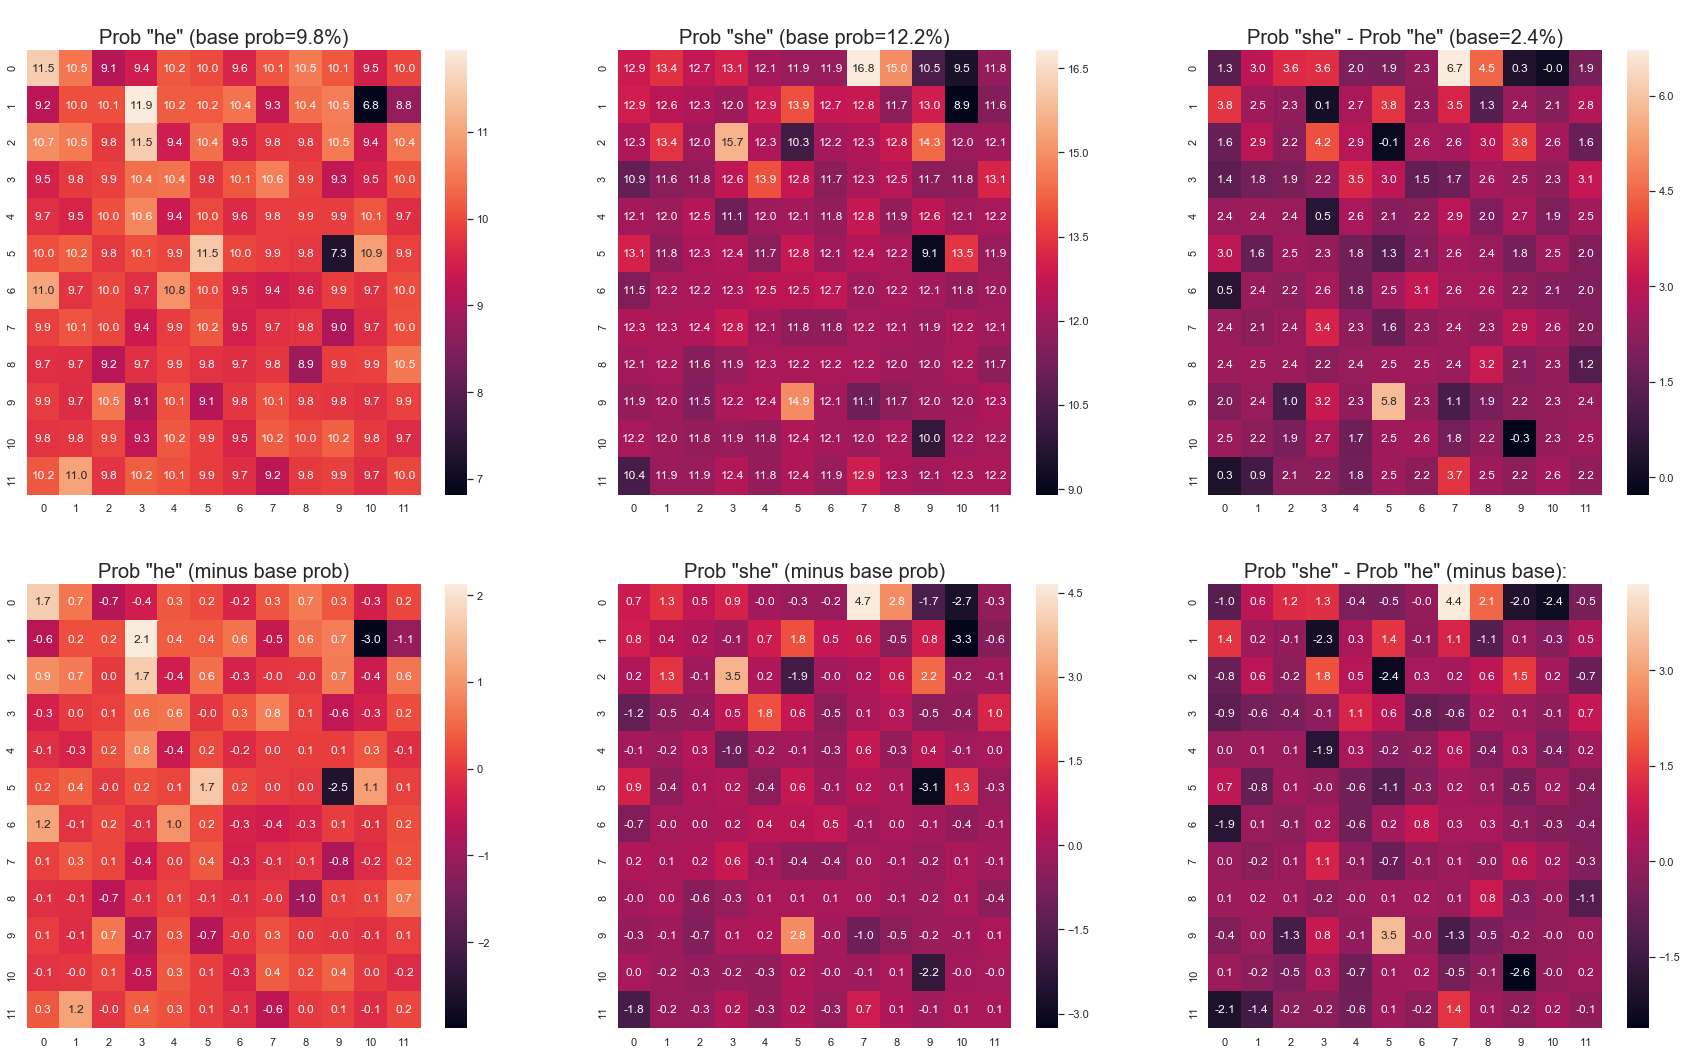

In [31]:
# print("{}: {:.2f}%".format(token, (base_probs[1] - base_probs[0]) * 100))

candidate1 = intervention.candidates[0][1:]
candidate2 = intervention.candidates[1][1:]
candidate1_base_prob = base_probs[0] * 100
candidate2_base_prob = base_probs[1] * 100

data = [
    (candidate1_probs, f'\nProb "{candidate1}" (base prob={candidate1_base_prob:.1f}%)'),
    (candidate2_probs, f'\nProb "{candidate2}" (base prob={candidate2_base_prob:.1f}%)'),
    (candidate2_probs - candidate1_probs, 
         f'\nProb "{candidate2}" - Prob "{candidate1}" (base={candidate2_base_prob - candidate1_base_prob:.1f}%)'),
    (candidate1_probs - candidate1_base_prob, f'\nProb "{candidate1}" (minus base prob)'),
    (candidate2_probs - candidate2_base_prob, f'\nProb "{candidate2}" (minus base prob)'),
    ((candidate2_probs - candidate1_probs) - (candidate2_base_prob - candidate1_base_prob),
         f'\nProb "{candidate2}" - Prob "{candidate1}" (minus base):')
]

visualize = True
if visualize:
    display(HTML("<style>.container { width:100% !important; }</style>"))
    sns.set()
    n_plots = 6
    plot_size_vert = 9
    plot_size_horiz = 10
    n_cols = 3
    n_rows = int(math.ceil(n_plots / n_cols))
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * plot_size_horiz, n_rows * plot_size_vert))
    for i, (arr, title) in enumerate(data):
        row = i // n_cols
        col = i % n_cols
        ax = sns.heatmap(arr, ax=axs[row][col], annot=True, fmt=".1f")
        ax.set_title(title, size=20)
else:
    torch.set_printoptions(precision=1, sci_mode=False)
    for arr, title in data:
        print("\n" + title)
        print(arr)
